In [11]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# load in correct answers
df_ans = pd.read_json("./datasets/data_mc.json", orient='records', lines=True)

# load in model predictions
df_dict_full = defaultdict(pd.DataFrame)

for file in os.listdir("results/eval3/"):
    if file.endswith(".json"):
        df = pd.read_json(os.path.join("./results/eval3/", file), orient='index') # transpose the dataframe
        df_dict_full[file.strip(".json")] = df

In [13]:
# normalize each row to probabilities for even comparison
# def softmax(x):
#     exp_x = np.exp(x - np.max(x))
#     return exp_x / np.sum(exp_x)

# for x, df in df_dict_full.items():
#     # in place softmax normalization on each row
#     df_dict_full[x] = df.apply(softmax, axis=1).fillna(0)
    
# use df_dict as subset of df_dict_full, excluding vanilla_t0.9 and dola_static24_t1.0, as well as any file that has top in it
df_dict = {k: v for k, v in df_dict_full.items() if 'top' not in k and 'vanilla_t0.9' not in k and 'dola_static24_t1.0' not in k}

In [14]:
# build dataframe of target: for each prompt in df_ans (each row), the probability of the correct answer (df_ans['answer'])
df_target_prob = pd.DataFrame()
df_target_penalty = pd.DataFrame()
df_target_rank = pd.DataFrame()

for i, row in df_ans.iterrows():
    # get the probability of the correct answer for each decoding strategy
    for x, df in df_dict.items():
        df_target_prob.loc[i, x] = df.loc[i, row['Answer']]

        # mask of incorrect answers
        df_target_penalty.loc[i, x] = (df.loc[i, :].idxmax() == row['Answer'])
        df_target_rank.loc[i, x] = df.loc[i, :].rank(method='min', ascending=False)[row['Answer']]


# target is one of the following: 

# 1) Decoding strategy that maximizes probability of correct answer 
theta = 0.0
y_prob = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)
# 2) Decoding strategy that maximize probability of correct answer with penalty for incorrect answers
theta = 0.1
y_prob_penalty = (df_target_prob - theta * df_target_penalty).idxmax(axis=1)

# 3) Rank of correct answer, default to dola_all_t1.0
df_copy = df_target_rank.copy()
df_copy['dola_all_t1.0'] -= 1e-10
y_rank = df_copy.idxmin(axis=1) # min = better

print(df_dict.keys())

dict_keys(['dola_s8_t1.0', 'dola_s0_t1.0', 'dola_s16_t1.0', 'dola_s24_t1.0', 'vanilla', 'dola_all_t1.0'])


In [16]:
# load in prompt data
df_train = pd.DataFrame(np.load("./datasets/embed_e5-large-v2.npy"), columns=[f"embed_{i}" for i in range(np.load("./datasets/embed_e5-large-v2.npy").shape[1])])
print("Prompt embedding shape:", df_train.shape)

# add in engineered tabular features
df_train['length'] = df_ans['Question'].str.len()
df_train['num_words'] = df_ans['Question'].str.split().str.len()
df_train['num_numbers'] = df_ans['Question'].str.count(r'\d+')
df_train['num_capital_letters'] = df_ans['Question'].str.count(r'[A-Z]')

print("Final feature shape:", df_train.shape)

Prompt embedding shape: (1570, 1024)
Final feature shape: (1570, 1028)


In [31]:
from sklearn.model_selection import train_test_split

# split indices into train and test
train_idx, test_idx = train_test_split(np.arange(len(df_ans)), test_size=0.3, random_state=42, stratify=df_ans['Type'])

y_bin = y_prob_penalty.apply(lambda x: 1 if 'dola' not in x else 0)
# y_target = y_prob_penalty.astype('category')
y_target = y_rank

# dicts to map decoding strategies to integers and vice versa
dec_dict = {k: i for i, k in enumerate(y_target.unique().sort_values())}
dec_dict_rev = {v: k for k, v in dec_dict.items()}
y_target = y_target.map(dec_dict).astype('int')

X_train = df_train.iloc[train_idx]
y_train = y_target.iloc[train_idx]
df_ans_train = df_ans.iloc[train_idx]

X_test = df_train.iloc[test_idx]
y_test = y_target.iloc[test_idx]
df_ans_test = df_ans.iloc[test_idx]

AttributeError: 'numpy.ndarray' object has no attribute 'sort_values'

In [43]:
from sklearn.model_selection import GridSearchCV
from tabpfn import TabPFNClassifier
from autogluon.tabular import TabularPredictor, TabularDataset
from autogluon.common import space
# from sklearn.linear_model import LogisticRegression

# try out different models, choose the best one via cross-validation

# # train model
# grid = GridSearchCV(
#     estimator=XGBClassifier(enable_categorical=True),
#     param_grid={
#         'n_estimators': [100, 200, 300],
#         # 'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [3, 4, 5]
#     },
#     cv=3,
#     n_jobs=-1
# )
# grid.fit(X_train, y_train)
# model = grid.best_estimator_

# model = TabPFNClassifier()
# model.fit(X_train, y_train)

hyperparameters = {
    # Logistic Regression (Linear Model in AutoGluon)
    'LR': {},
    
    # XGBoost
    'XGB': {
        # 'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(3, 5),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # LightGBM
    'GBM': {
        # 'ag_args_ensemble': {'fold_fitting_strategy': 'sequential_local'},
        'num_boost_round': space.Int(100, 300),
        'num_leaves': space.Int(31, 127),
        'learning_rate': space.Real(0.01, 0.1),
    },
    
    # Random Forest
    'RF': {
        'n_estimators': space.Int(100, 300),
        'max_depth': space.Int(None, 5),
        'max_features': space.Categorical(['sqrt', 'log2', None]),
    },
    
    # TabPFN (if installed)
    'TABPFNV2': {},
    'MITRA': {
        'fine_tune': True,
        'fine_tune_steps': 10
    }
}

hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler': 'local',
    'searcher': 'auto',
    'time_limit': 3600,
    # 'num_gpus': 1,
}

label = 'best_dec'
y_train.name = label
y_test.name = label
train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

predictor = TabularPredictor(
    label=label, 
    verbosity=3, 
    eval_metric='roc_auc_ovo',
    path='./results/autogluon_models/',

).fit(
    train_data,
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    presets='medium_quality',
    # num_gpus=1,
    # memory_limit=16,
    # dynamic_stacking=False
)

Verbosity: 4 (Maximum Logging)
loky.cpu_count(only_physical_cores=False): 11
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Wed Dec 20 21:30:59 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T6030
CPU Count:          11
GPU Count:          1
Memory Avail:       3.45 GB / 18.00 GB (19.2%)
Disk Space Avail:   145.66 GB / 460.43 GB (31.6%)
Presets specified: ['medium_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False,
 'hyperparameter_tune_kwargs': {'num_trials': 10,
                                'scheduler': 'local',
                                'searcher': 'auto',
                                'time_limit': 3600}}
Full kwargs:
{'_experimental_dynamic_hyperparameters': False,
 '_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None

[1]	valid_set's multi_logloss: 1.27626	valid_set's roc_auc_ovo: 0.4628
[2]	valid_set's multi_logloss: 1.27469	valid_set's roc_auc_ovo: 0.483042
[3]	valid_set's multi_logloss: 1.27429	valid_set's roc_auc_ovo: 0.490007
[4]	valid_set's multi_logloss: 1.27287	valid_set's roc_auc_ovo: 0.490539
[5]	valid_set's multi_logloss: 1.27216	valid_set's roc_auc_ovo: 0.492712
[6]	valid_set's multi_logloss: 1.27131	valid_set's roc_auc_ovo: 0.485123
[7]	valid_set's multi_logloss: 1.27034	valid_set's roc_auc_ovo: 0.496715
[8]	valid_set's multi_logloss: 1.26978	valid_set's roc_auc_ovo: 0.489321
[9]	valid_set's multi_logloss: 1.26833	valid_set's roc_auc_ovo: 0.493095
[10]	valid_set's multi_logloss: 1.26747	valid_set's roc_auc_ovo: 0.499231
[11]	valid_set's multi_logloss: 1.26623	valid_set's roc_auc_ovo: 0.48861
[12]	valid_set's multi_logloss: 1.26427	valid_set's roc_auc_ovo: 0.509366
[13]	valid_set's multi_logloss: 1.26281	valid_set's roc_auc_ovo: 0.519389
[14]	valid_set's multi_logloss: 1.26248	valid_set'

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T1/model.pkl
 10%|█         | 1/10 [00:07<01:06,  7.42s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl


[98]	valid_set's multi_logloss: 1.24974	valid_set's roc_auc_ovo: 0.584389
[99]	valid_set's multi_logloss: 1.24992	valid_set's roc_auc_ovo: 0.584235
[100]	valid_set's multi_logloss: 1.25012	valid_set's roc_auc_ovo: 0.584089


	Fitting 295 rounds... Hyperparameters: {'learning_rate': 0.07436704297351776, 'num_leaves': 40, 'feature_fraction': 0.8872033759818312, 'min_data_in_leaf': 5}


[1]	valid_set's multi_logloss: 1.30655	valid_set's roc_auc_ovo: 0.516465
[2]	valid_set's multi_logloss: 1.29984	valid_set's roc_auc_ovo: 0.487897
[3]	valid_set's multi_logloss: 1.29982	valid_set's roc_auc_ovo: 0.480537
[4]	valid_set's multi_logloss: 1.30044	valid_set's roc_auc_ovo: 0.480064
[5]	valid_set's multi_logloss: 1.30378	valid_set's roc_auc_ovo: 0.477706
[6]	valid_set's multi_logloss: 1.30469	valid_set's roc_auc_ovo: 0.477097
[7]	valid_set's multi_logloss: 1.30663	valid_set's roc_auc_ovo: 0.479114
[8]	valid_set's multi_logloss: 1.30315	valid_set's roc_auc_ovo: 0.481479
[9]	valid_set's multi_logloss: 1.29823	valid_set's roc_auc_ovo: 0.486385
[10]	valid_set's multi_logloss: 1.30381	valid_set's roc_auc_ovo: 0.48866
[11]	valid_set's multi_logloss: 1.30724	valid_set's roc_auc_ovo: 0.492274
[12]	valid_set's multi_logloss: 1.30717	valid_set's roc_auc_ovo: 0.49395
[13]	valid_set's multi_logloss: 1.31065	valid_set's roc_auc_ovo: 0.494785
[14]	valid_set's multi_logloss: 1.31361	valid_set

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T2/model.pkl
 20%|██        | 2/10 [00:20<01:25, 10.69s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 170 rounds... Hyperparameters: {'learning_rate': 0.04459435365634299, 'num_leaves': 119, 'feature_fraction': 0.9058909241964931, 'min_data_in_leaf': 25}


[1]	valid_set's multi_logloss: 1.26988	valid_set's roc_auc_ovo: 0.563973
[2]	valid_set's multi_logloss: 1.2666	valid_set's roc_auc_ovo: 0.566202
[3]	valid_set's multi_logloss: 1.26365	valid_set's roc_auc_ovo: 0.542578
[4]	valid_set's multi_logloss: 1.25834	valid_set's roc_auc_ovo: 0.546775
[5]	valid_set's multi_logloss: 1.25576	valid_set's roc_auc_ovo: 0.558877
[6]	valid_set's multi_logloss: 1.25316	valid_set's roc_auc_ovo: 0.547833
[7]	valid_set's multi_logloss: 1.25263	valid_set's roc_auc_ovo: 0.555523
[8]	valid_set's multi_logloss: 1.25497	valid_set's roc_auc_ovo: 0.533636
[9]	valid_set's multi_logloss: 1.25344	valid_set's roc_auc_ovo: 0.528181
[10]	valid_set's multi_logloss: 1.25169	valid_set's roc_auc_ovo: 0.52735
[11]	valid_set's multi_logloss: 1.24955	valid_set's roc_auc_ovo: 0.545633
[12]	valid_set's multi_logloss: 1.24933	valid_set's roc_auc_ovo: 0.556206
[13]	valid_set's multi_logloss: 1.24552	valid_set's roc_auc_ovo: 0.553964
[14]	valid_set's multi_logloss: 1.24501	valid_set

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T3/model.pkl


[167]	valid_set's multi_logloss: 1.69399	valid_set's roc_auc_ovo: 0.618465
[168]	valid_set's multi_logloss: 1.69969	valid_set's roc_auc_ovo: 0.622852
[169]	valid_set's multi_logloss: 1.70616	valid_set's roc_auc_ovo: 0.619719
[170]	valid_set's multi_logloss: 1.71054	valid_set's roc_auc_ovo: 0.619071


 30%|███       | 3/10 [00:30<01:13, 10.54s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 139 rounds... Hyperparameters: {'learning_rate': 0.04450973669432, 'num_leaves': 118, 'feature_fraction': 0.9909156901252574, 'min_data_in_leaf': 40}


[1]	valid_set's multi_logloss: 1.26969	valid_set's roc_auc_ovo: 0.55225
[2]	valid_set's multi_logloss: 1.26387	valid_set's roc_auc_ovo: 0.632156
[3]	valid_set's multi_logloss: 1.26334	valid_set's roc_auc_ovo: 0.595788
[4]	valid_set's multi_logloss: 1.25958	valid_set's roc_auc_ovo: 0.592333
[5]	valid_set's multi_logloss: 1.25341	valid_set's roc_auc_ovo: 0.596501
[6]	valid_set's multi_logloss: 1.25225	valid_set's roc_auc_ovo: 0.606212
[7]	valid_set's multi_logloss: 1.25261	valid_set's roc_auc_ovo: 0.613614
[8]	valid_set's multi_logloss: 1.24945	valid_set's roc_auc_ovo: 0.589423
[9]	valid_set's multi_logloss: 1.24833	valid_set's roc_auc_ovo: 0.597836
[10]	valid_set's multi_logloss: 1.24459	valid_set's roc_auc_ovo: 0.607988
[11]	valid_set's multi_logloss: 1.23961	valid_set's roc_auc_ovo: 0.615309
[12]	valid_set's multi_logloss: 1.23207	valid_set's roc_auc_ovo: 0.640086
[13]	valid_set's multi_logloss: 1.22764	valid_set's roc_auc_ovo: 0.644988
[14]	valid_set's multi_logloss: 1.22712	valid_se

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T4/model.pkl
 40%|████      | 4/10 [00:36<00:52,  8.81s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 177 rounds... Hyperparameters: {'learning_rate': 0.04535063164907468, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}


[1]	valid_set's multi_logloss: 1.27244	valid_set's roc_auc_ovo: 0.558587
[2]	valid_set's multi_logloss: 1.26797	valid_set's roc_auc_ovo: 0.540494
[3]	valid_set's multi_logloss: 1.25996	valid_set's roc_auc_ovo: 0.602031
[4]	valid_set's multi_logloss: 1.25496	valid_set's roc_auc_ovo: 0.624448
[5]	valid_set's multi_logloss: 1.24806	valid_set's roc_auc_ovo: 0.634064
[6]	valid_set's multi_logloss: 1.24672	valid_set's roc_auc_ovo: 0.640567
[7]	valid_set's multi_logloss: 1.24279	valid_set's roc_auc_ovo: 0.652857
[8]	valid_set's multi_logloss: 1.2403	valid_set's roc_auc_ovo: 0.623936
[9]	valid_set's multi_logloss: 1.2393	valid_set's roc_auc_ovo: 0.619535
[10]	valid_set's multi_logloss: 1.23959	valid_set's roc_auc_ovo: 0.592426
[11]	valid_set's multi_logloss: 1.23484	valid_set's roc_auc_ovo: 0.597332
[12]	valid_set's multi_logloss: 1.23163	valid_set's roc_auc_ovo: 0.587736
[13]	valid_set's multi_logloss: 1.23109	valid_set's roc_auc_ovo: 0.607622
[14]	valid_set's multi_logloss: 1.23389	valid_set

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T5/model.pkl
 50%|█████     | 5/10 [00:46<00:45,  9.11s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 297 rounds... Hyperparameters: {'learning_rate': 0.011819655769629315, 'num_leaves': 110, 'feature_fraction': 0.7717823249253852, 'min_data_in_leaf': 53}


[176]	valid_set's multi_logloss: 1.75794	valid_set's roc_auc_ovo: 0.613091
[177]	valid_set's multi_logloss: 1.76434	valid_set's roc_auc_ovo: 0.612699
[1]	valid_set's multi_logloss: 1.27536	valid_set's roc_auc_ovo: 0.472048
[2]	valid_set's multi_logloss: 1.27272	valid_set's roc_auc_ovo: 0.649035
[3]	valid_set's multi_logloss: 1.27166	valid_set's roc_auc_ovo: 0.638707
[4]	valid_set's multi_logloss: 1.27039	valid_set's roc_auc_ovo: 0.6137
[5]	valid_set's multi_logloss: 1.26922	valid_set's roc_auc_ovo: 0.613257
[6]	valid_set's multi_logloss: 1.26844	valid_set's roc_auc_ovo: 0.593372
[7]	valid_set's multi_logloss: 1.26704	valid_set's roc_auc_ovo: 0.603375
[8]	valid_set's multi_logloss: 1.26556	valid_set's roc_auc_ovo: 0.602767
[9]	valid_set's multi_logloss: 1.26454	valid_set's roc_auc_ovo: 0.607429
[10]	valid_set's multi_logloss: 1.26341	valid_set's roc_auc_ovo: 0.6142
[11]	valid_set's multi_logloss: 1.26181	valid_set's roc_auc_ovo: 0.623449
[12]	valid_set's multi_logloss: 1.2607	valid_set'

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T6/model.pkl
 60%|██████    | 6/10 [00:55<00:36,  9.07s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl


[293]	valid_set's multi_logloss: 1.27868	valid_set's roc_auc_ovo: 0.648336
[294]	valid_set's multi_logloss: 1.2792	valid_set's roc_auc_ovo: 0.647572
[295]	valid_set's multi_logloss: 1.27973	valid_set's roc_auc_ovo: 0.648259
[296]	valid_set's multi_logloss: 1.28008	valid_set's roc_auc_ovo: 0.648339
[297]	valid_set's multi_logloss: 1.28024	valid_set's roc_auc_ovo: 0.648596


	Fitting 277 rounds... Hyperparameters: {'learning_rate': 0.09807565080094877, 'num_leaves': 60, 'feature_fraction': 0.9675030370617048, 'min_data_in_leaf': 26}


[1]	valid_set's multi_logloss: 1.26692	valid_set's roc_auc_ovo: 0.561786
[2]	valid_set's multi_logloss: 1.25375	valid_set's roc_auc_ovo: 0.605347
[3]	valid_set's multi_logloss: 1.25212	valid_set's roc_auc_ovo: 0.581676
[4]	valid_set's multi_logloss: 1.24721	valid_set's roc_auc_ovo: 0.613205
[5]	valid_set's multi_logloss: 1.2458	valid_set's roc_auc_ovo: 0.574103
[6]	valid_set's multi_logloss: 1.2431	valid_set's roc_auc_ovo: 0.562196
[7]	valid_set's multi_logloss: 1.24305	valid_set's roc_auc_ovo: 0.586894
[8]	valid_set's multi_logloss: 1.24245	valid_set's roc_auc_ovo: 0.632029
[9]	valid_set's multi_logloss: 1.24255	valid_set's roc_auc_ovo: 0.628249
[10]	valid_set's multi_logloss: 1.24191	valid_set's roc_auc_ovo: 0.619963
[11]	valid_set's multi_logloss: 1.24206	valid_set's roc_auc_ovo: 0.622272
[12]	valid_set's multi_logloss: 1.24122	valid_set's roc_auc_ovo: 0.632148
[13]	valid_set's multi_logloss: 1.24521	valid_set's roc_auc_ovo: 0.628506
[14]	valid_set's multi_logloss: 1.24441	valid_set

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T7/model.pkl
 70%|███████   | 7/10 [01:04<00:27,  9.04s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl


[260]	valid_set's multi_logloss: 2.38239	valid_set's roc_auc_ovo: 0.633641
[261]	valid_set's multi_logloss: 2.38123	valid_set's roc_auc_ovo: 0.633413
[262]	valid_set's multi_logloss: 2.38254	valid_set's roc_auc_ovo: 0.633265
[263]	valid_set's multi_logloss: 2.38461	valid_set's roc_auc_ovo: 0.632747
[264]	valid_set's multi_logloss: 2.38328	valid_set's roc_auc_ovo: 0.632406
[265]	valid_set's multi_logloss: 2.38492	valid_set's roc_auc_ovo: 0.632307
[266]	valid_set's multi_logloss: 2.3836	valid_set's roc_auc_ovo: 0.632214
[267]	valid_set's multi_logloss: 2.38508	valid_set's roc_auc_ovo: 0.632787
[268]	valid_set's multi_logloss: 2.38592	valid_set's roc_auc_ovo: 0.632873
[269]	valid_set's multi_logloss: 2.38539	valid_set's roc_auc_ovo: 0.633083
[270]	valid_set's multi_logloss: 2.38482	valid_set's roc_auc_ovo: 0.632737
[271]	valid_set's multi_logloss: 2.38575	valid_set's roc_auc_ovo: 0.632787
[272]	valid_set's multi_logloss: 2.38474	valid_set's roc_auc_ovo: 0.632349
[273]	valid_set's multi_lo

	Fitting 293 rounds... Hyperparameters: {'learning_rate': 0.02064469832820399, 'num_leaves': 40, 'feature_fraction': 0.9451322940716138, 'min_data_in_leaf': 34}


[1]	valid_set's multi_logloss: 1.27392	valid_set's roc_auc_ovo: 0.50782
[2]	valid_set's multi_logloss: 1.27111	valid_set's roc_auc_ovo: 0.537076
[3]	valid_set's multi_logloss: 1.26895	valid_set's roc_auc_ovo: 0.553019
[4]	valid_set's multi_logloss: 1.26585	valid_set's roc_auc_ovo: 0.537478
[5]	valid_set's multi_logloss: 1.26319	valid_set's roc_auc_ovo: 0.552968
[6]	valid_set's multi_logloss: 1.26256	valid_set's roc_auc_ovo: 0.53305
[7]	valid_set's multi_logloss: 1.26065	valid_set's roc_auc_ovo: 0.541586
[8]	valid_set's multi_logloss: 1.25901	valid_set's roc_auc_ovo: 0.564877
[9]	valid_set's multi_logloss: 1.25694	valid_set's roc_auc_ovo: 0.560689
[10]	valid_set's multi_logloss: 1.25589	valid_set's roc_auc_ovo: 0.551927
[11]	valid_set's multi_logloss: 1.25435	valid_set's roc_auc_ovo: 0.563552
[12]	valid_set's multi_logloss: 1.25302	valid_set's roc_auc_ovo: 0.566592
[13]	valid_set's multi_logloss: 1.25169	valid_set's roc_auc_ovo: 0.583466
[14]	valid_set's multi_logloss: 1.25177	valid_set

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T8/model.pkl
 80%|████████  | 8/10 [01:18<00:21, 10.58s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 251 rounds... Hyperparameters: {'learning_rate': 0.07827540618901214, 'num_leaves': 66, 'feature_fraction': 0.8843433073622526, 'min_data_in_leaf': 12}


[293]	valid_set's multi_logloss: 1.51767	valid_set's roc_auc_ovo: 0.621788
[1]	valid_set's multi_logloss: 1.26725	valid_set's roc_auc_ovo: 0.510172
[2]	valid_set's multi_logloss: 1.25594	valid_set's roc_auc_ovo: 0.505244
[3]	valid_set's multi_logloss: 1.24718	valid_set's roc_auc_ovo: 0.517922
[4]	valid_set's multi_logloss: 1.24469	valid_set's roc_auc_ovo: 0.514857
[5]	valid_set's multi_logloss: 1.24083	valid_set's roc_auc_ovo: 0.515339
[6]	valid_set's multi_logloss: 1.23339	valid_set's roc_auc_ovo: 0.519426
[7]	valid_set's multi_logloss: 1.2346	valid_set's roc_auc_ovo: 0.532142
[8]	valid_set's multi_logloss: 1.23684	valid_set's roc_auc_ovo: 0.536545
[9]	valid_set's multi_logloss: 1.23765	valid_set's roc_auc_ovo: 0.532102
[10]	valid_set's multi_logloss: 1.23958	valid_set's roc_auc_ovo: 0.540931
[11]	valid_set's multi_logloss: 1.24198	valid_set's roc_auc_ovo: 0.524235
[12]	valid_set's multi_logloss: 1.24652	valid_set's roc_auc_ovo: 0.521155
[13]	valid_set's multi_logloss: 1.24687	valid_s

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T9/model.pkl


[237]	valid_set's multi_logloss: 2.31651	valid_set's roc_auc_ovo: 0.58911
[238]	valid_set's multi_logloss: 2.3177	valid_set's roc_auc_ovo: 0.588934
[239]	valid_set's multi_logloss: 2.31715	valid_set's roc_auc_ovo: 0.588592
[240]	valid_set's multi_logloss: 2.31957	valid_set's roc_auc_ovo: 0.588469
[241]	valid_set's multi_logloss: 2.3189	valid_set's roc_auc_ovo: 0.588879
[242]	valid_set's multi_logloss: 2.31959	valid_set's roc_auc_ovo: 0.589036
[243]	valid_set's multi_logloss: 2.32045	valid_set's roc_auc_ovo: 0.588911
[244]	valid_set's multi_logloss: 2.32017	valid_set's roc_auc_ovo: 0.58902
[245]	valid_set's multi_logloss: 2.32076	valid_set's roc_auc_ovo: 0.588775
[246]	valid_set's multi_logloss: 2.3188	valid_set's roc_auc_ovo: 0.592658
[247]	valid_set's multi_logloss: 2.31916	valid_set's roc_auc_ovo: 0.592866
[248]	valid_set's multi_logloss: 2.31932	valid_set's roc_auc_ovo: 0.593965
[249]	valid_set's multi_logloss: 2.32015	valid_set's roc_auc_ovo: 0.593889
[250]	valid_set's multi_loglos

 90%|█████████ | 9/10 [01:31<00:11, 11.49s/it]Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_train.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/dataset_val.pkl
	Fitting 134 rounds... Hyperparameters: {'learning_rate': 0.07632263594160624, 'num_leaves': 31, 'feature_fraction': 0.79658308583169, 'min_data_in_leaf': 30}


[1]	valid_set's multi_logloss: 1.26857	valid_set's roc_auc_ovo: 0.530168
[2]	valid_set's multi_logloss: 1.25888	valid_set's roc_auc_ovo: 0.588432
[3]	valid_set's multi_logloss: 1.2516	valid_set's roc_auc_ovo: 0.607995
[4]	valid_set's multi_logloss: 1.25126	valid_set's roc_auc_ovo: 0.584471
[5]	valid_set's multi_logloss: 1.24124	valid_set's roc_auc_ovo: 0.618266
[6]	valid_set's multi_logloss: 1.24122	valid_set's roc_auc_ovo: 0.62265
[7]	valid_set's multi_logloss: 1.23972	valid_set's roc_auc_ovo: 0.608174
[8]	valid_set's multi_logloss: 1.24092	valid_set's roc_auc_ovo: 0.597728
[9]	valid_set's multi_logloss: 1.24596	valid_set's roc_auc_ovo: 0.557393
[10]	valid_set's multi_logloss: 1.24986	valid_set's roc_auc_ovo: 0.578103
[11]	valid_set's multi_logloss: 1.25488	valid_set's roc_auc_ovo: 0.553464
[12]	valid_set's multi_logloss: 1.26019	valid_set's roc_auc_ovo: 0.532486
[13]	valid_set's multi_logloss: 1.26548	valid_set's roc_auc_ovo: 0.550941
[14]	valid_set's multi_logloss: 1.2719	valid_set'

Saving /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T10/model.pkl
100%|██████████| 10/10 [01:38<00:00,  9.82s/it]
Time for LightGBM model HPO: 98.23701691627502
Best hyperparameter configuration for LightGBM model: 
{'learning_rate': 0.04535063164907468, 'num_boost_round': 177, 'num_leaves': 103, 'feature_fraction': 0.8699942930937643, 'min_data_in_leaf': 27}
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T1/model.pkl
Fitted model: LightGBM/T1 ...
	0.5844	 = Validation score   (roc_auc_ovo)
	7.38s	 = Training   runtime
	0.0s	 = Validation runtime
	48639.9	 = Inference  throughput (rows/s | 220 batch size)
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T2/model.pkl
Fitted model: LightGBM/T2 ...
	0.6017	 = Validation score   (roc_auc_ovo)
	12.92s	 = Training   runtime
	0.01s	 = Validation runtime
	37326.4	 = Inference  throughput (rows/s | 220 batch size)
Loading: 

[133]	valid_set's multi_logloss: 1.97981	valid_set's roc_auc_ovo: 0.594464
[134]	valid_set's multi_logloss: 1.98686	valid_set's roc_auc_ovo: 0.594585


	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=19.71 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
Traceback (most recent call last):
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/tabular/trainer/abstract_trainer.py", line 2572, in _train_single_full
    hpo_models, hpo_results = model.hyperparameter_tune(
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1968, in hyperparameter_tune
    self._validate_fit_memory_usage(**kwargs)
  File "/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/a

In [48]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# evaluate model just in terms of accuracy/roc in predicting best decoding strategy
# y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)

y_pred_proba = predictor.predict_proba(X_test)
y_pred = y_pred_proba.values.argmax(axis=1)
# print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))
# print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)}")

predictor.leaderboard(test_data, silent=True)

Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T5/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T1/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T2/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T3/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T4/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T5/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T6/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/results/autogluon_models/models/LightGBM/T7/model.pkl
Loading: /Users/roku/academic/15.099/project/DoLa/result

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LinearModel/T9,0.618665,0.589470,roc_auc_ovo,0.009228,0.008577,0.291502,0.009228,0.008577,0.291502,1,True,19
1,LinearModel/T4,0.611499,0.594780,roc_auc_ovo,0.009282,0.007008,1.433075,0.009282,0.007008,1.433075,1,True,14
2,LinearModel/T5,0.610858,0.593986,roc_auc_ovo,0.011038,0.008575,0.275909,0.011038,0.008575,0.275909,1,True,15
3,LinearModel/T7,0.608316,0.590750,roc_auc_ovo,0.011420,0.006849,1.502352,0.011420,0.006849,1.502352,1,True,17
4,LinearModel/T2,0.608172,0.587208,roc_auc_ovo,0.010316,0.007934,1.861601,0.010316,0.007934,1.861601,1,True,12
5,LightGBM/T5,0.536032,0.652857,roc_auc_ovo,0.005339,0.002723,9.623880,0.005339,0.002723,9.623880,1,True,5
6,WeightedEnsemble_L2,0.536032,0.652857,roc_auc_ovo,0.007033,0.008969,9.872398,0.001694,0.006246,0.248518,2,True,21
7,LightGBM/T6,0.535482,0.649035,roc_auc_ovo,0.004306,0.002527,8.980171,0.004306,0.002527,8.980171,1,True,6
8,LightGBM/T4,0.518963,0.651324,roc_auc_ovo,0.006491,0.002260,6.142041,0.006491,0.002260,6.142041,1,True,4
9,LightGBM/T1,0.512993,0.584389,roc_auc_ovo,0.018698,0.004523,7.383941,0.018698,0.004523,7.383941,1,True,1


In [94]:
#roc ovr per class:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', labels=np.arange(len(df_dict)), average=None)
print(roc_auc)
for i, r in enumerate(roc_auc):
    print(f"ROC AUC for class {dec_dict_rev[i]}: {r}")

[0.57199971        nan 0.44800443 0.69614665 0.60862523 0.58689018]
ROC AUC for class dola_all_t1.0: 0.5719997105539274
ROC AUC for class dola_s0_t1.0: nan
ROC AUC for class dola_s16_t1.0: 0.44800443458980044
ROC AUC for class dola_s24_t1.0: 0.6961466517022071
ROC AUC for class dola_s8_t1.0: 0.6086252277789026
ROC AUC for class vanilla: 0.58689017837954


/Users/roku/miniconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [49]:
# evaluate model on prompts (how much better is the dynamic strategy than the static strategy?)
acc_on_prompts = {t: {} for t in df_ans_test['Type'].unique()}

# first, get accuracy of plain decoding strategies on prompts
for x, df in df_dict_full.items():
    print("accuracy of", x, ":")
    y_pred_dec = df.iloc[test_idx, :].idxmax(axis=1)
    print(f" - Total:{accuracy_score(df_ans_test['Answer'], y_pred_dec)}")
    print(" - By question type:")
    for t in df_ans_test['Type'].unique():
        acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], y_pred_dec[df_ans_test['Type'] == t])
        acc_on_prompts[t][x] = acc_on_t
        print(f"   - {t}: {acc_on_t}")

print("--------------------------------")
# then, get accuracy of model on prompts
y_pred_model = []
for i, (idx, row) in enumerate(df_ans_test.iterrows()):
    # randomly choose a dola decoding strategy
    dec = dec_dict_rev[y_pred[i]]
    y_pred_model.append(df_dict[dec].iloc[idx, :].idxmax(axis=0))

print(f"Accuracy of model: {accuracy_score(df_ans_test['Answer'], pd.Series(y_pred_model))}")
print(" - By question type:")
for t in df_ans_test['Type'].unique():
    acc_on_t = accuracy_score(df_ans_test[df_ans_test['Type'] == t]['Answer'], np.array(y_pred_model)[df_ans_test['Type'] == t])
    acc_on_prompts[t]['model'] = acc_on_t
    print(f"   - {t}: {acc_on_t}")

accuracy of dola_s8_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.30833333333333335
   - TruthfulQA: 0.3853658536585366
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.3375
   - college_computer_science: 0.36666666666666664
accuracy of dola_s0_t1.0 :
 - Total:0.3673036093418259
 - By question type:
   - HellaSwag: 0.3
   - TruthfulQA: 0.3804878048780488
   - international_law: 0.5277777777777778
   - clinical_knowledge: 0.375
   - college_computer_science: 0.3333333333333333
accuracy of top_p0.9_t1.0 :
 - Total:0.28450106157112526
 - By question type:
   - HellaSwag: 0.39166666666666666
   - TruthfulQA: 0.24390243902439024
   - international_law: 0.2777777777777778
   - clinical_knowledge: 0.2625
   - college_computer_science: 0.2
accuracy of dola_s16_t1.0 :
 - Total:0.37579617834394907
 - By question type:
   - HellaSwag: 0.3416666666666667
   - TruthfulQA: 0.37073170731707317
   - international_law: 0.5277777777777778
   - clinical_kn

In [52]:
for i in range(len(y_pred)):
    print(dec_dict_rev[y_pred[i]])

dola_all_t1.0
dola_all_t1.0
vanilla
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
vanilla
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
vanilla
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
vanilla
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
dola_all_t1.0
do

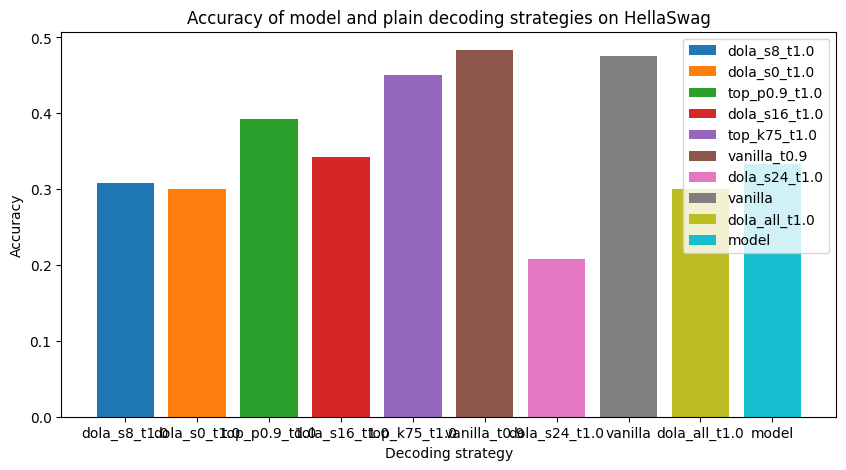

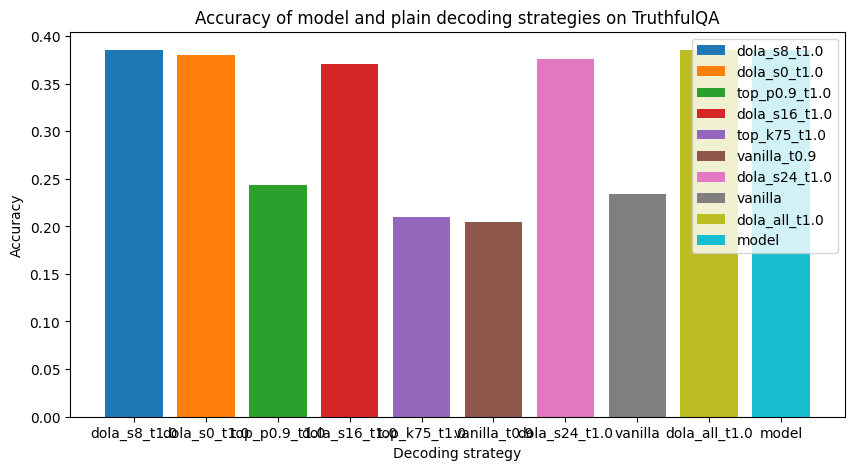

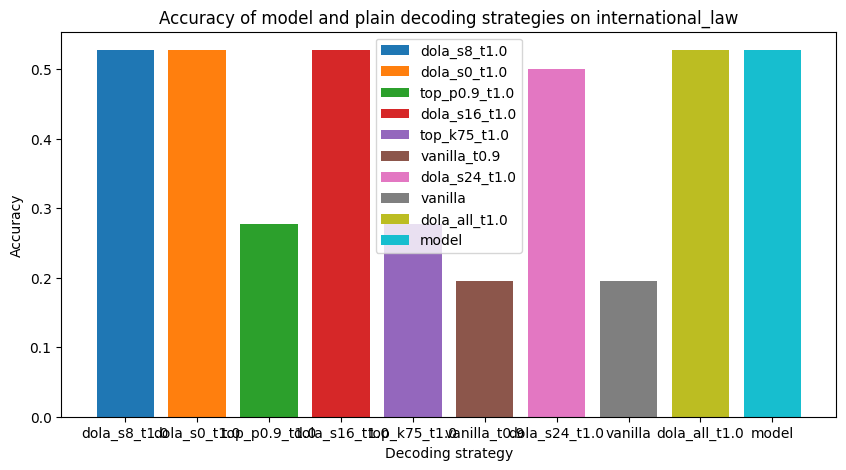

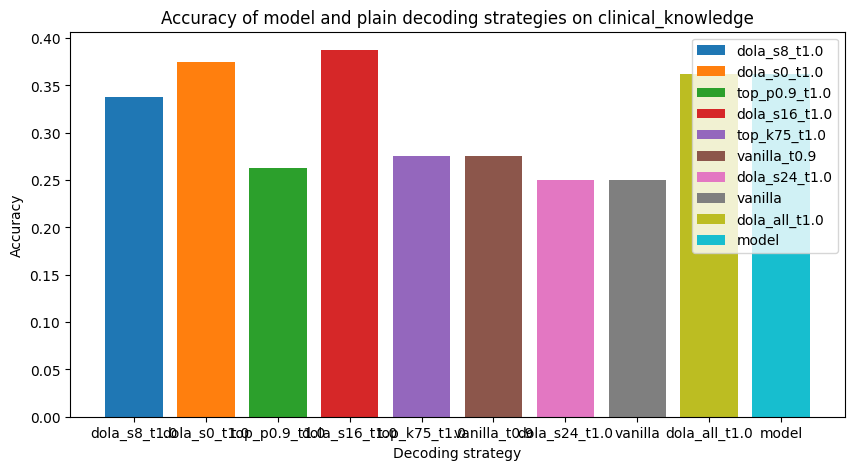

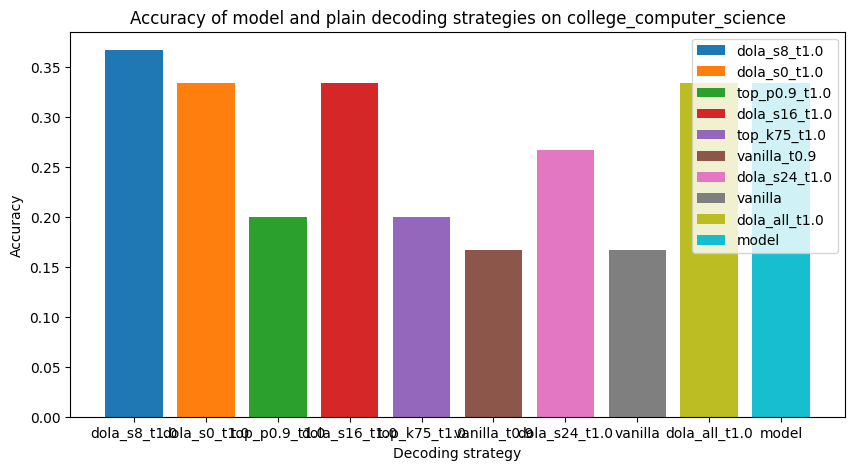

In [50]:
# for each type, plot the accuracy of the model and the plain decoding strategies
# add title, xlabel, ylabel, as well as a legend, and way to differentiate model and plain decoding strategies
# we need 5 plots, one for each question type
for t in df_ans_test['Type'].unique(): 
    plt.figure(figsize=(10, 5))
    xs = list(acc_on_prompts[t].keys())
    plt.bar(xs, [acc_on_prompts[t][x] for x in acc_on_prompts[t].keys()], label=xs, color=plt.cm.tab10.colors)
    plt.title(f"Accuracy of model and plain decoding strategies on {t}")
    plt.xlabel("Decoding strategy")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [52]:
pd.DataFrame([dec_dict_rev[y_pred[i]] for i in range(len(y_pred))]).value_counts()

0            
dola_all_t1.0    348
vanilla_t0.9     116
dola_s24_t1.0      7
Name: count, dtype: int64

In [23]:
df_ans['Type'].value_counts()

Type
TruthfulQA                  684
clinical_knowledge          265
international_law           121
college_computer_science    100
Name: count, dtype: int64

In [ ]:
# inference for Vicuna-eval questions
